# 实验五：AAAI 会议论文聚类分析
本次实验以AAAI 2014会议论文数据为基础，要求实现或调用无监督聚类算法，了解聚类方法。

## 1 任务介绍
每年国际上召开的大大小小学术会议不计其数，发表了非常多的论文。在计算机领域的一些大型学术会议上，一次就可以发表涉及各个方向的几百篇论文。按论文的主题、内容进行聚类，有助于人们高效地查找和获得所需要的论文。本案例数据来源于AAAI 2014上发表的约400篇文章，由[UCI](https://archive.ics.uci.edu/ml/datasets/AAAI+2014+Accepted+Papers!)公开提供，提供包括标题、作者、关键词、摘要在内的信息，希望大家能根据这些信息，合理地构造特征向量来表示这些论文，并设计实现或调用聚类算法对论文进行聚类。最后也可以对聚类结果进行观察，看每一类都是什么样的论文，是否有一些主题。

基本要求：
1. 将文本转化为向量，实现或调用无监督聚类算法，对论文聚类，例如10类（可使用已有工具包例如sklearn）；
2. 观察每一类中的论文，调整算法使结果较为合理；
3. 无监督聚类没有标签，效果较难评价，因此没有硬性指标，跑通即可，主要让大家了解和感受聚类算法，比较简单。

扩展要求：
1. 对文本向量进行降维，并将聚类结果可视化成散点图。

注：group和topic也不能完全算是标签，因为
1. 有些文章作者投稿时可能会选择某个group/topic但实际和另外group/topic也相关甚至更相关；
2. 一篇文章可能有多个group和topic，作为标签会出现有的文章同属多个类别，这里暂不考虑这样的聚类；
3. group和topic的取值很多，但聚类常常希望指定聚合成出例如5/10/20类；
4. 感兴趣但同学可以思考利用group和topic信息来量化评价无监督聚类结果，不作要求。

提示：
1. 高维向量的降维旨在去除一些高相关性的特征维度，保留最有用的信息，用更低维的向量表示高维数据，常用的方法有PCA和t-SNE等；
2. 降维与聚类是两件不同的事情，聚类实际上在降维前的高维向量和降维后的低维向量上都可以进行，结果也可能截然不同；
3. 高维向量做聚类，降维可视化后若有同一类的点不在一起，是正常的。在高维空间中它们可能是在一起的，降维后损失了一些信息。

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import re
import nltk
import sklearn
import seaborn as sns # 作图
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import sparse # 稀疏矩阵

RANDOM_STATE = 2023

### 2 导入数据

In [2]:
data_df = pd.read_csv('./data/[UCI] AAAI-14 Accepted Papers - Papers.csv') # 读入 csv 文件为 pandas 的 DataFrame
data_df.head(5) 

,title,authors,groups,keywords,topics,abstract
0,Kernelized Bayesian Transfer Learning,Mehmet Gönen and Adam A. Margolin,Novel Machine Learning Algorithms (NMLA),cross-domain learning\r\ndomain adaptation\r\n...,APP: Biomedical / Bioinformatics\r\nNMLA: Baye...,Transfer learning considers related but distin...
1,"""Source Free"" Transfer Learning for Text Class...","Zhongqi Lu, Yin Zhu, Sinno Pan, Evan Xiang, Yu...",AI and the Web (AIW)\r\nNovel Machine Learning...,Transfer Learning\r\nAuxiliary Data Retrieval\...,AIW: Knowledge acquisition from the web\r\nAIW...,Transfer learning uses relevant auxiliary data...
2,A Generalization of Probabilistic Serial to Ra...,Haris Aziz and Paul Stursberg,Game Theory and Economic Paradigms (GTEP),social choice theory\r\nvoting\r\nfair divisio...,GTEP: Game Theory\r\nGTEP: Social Choice / Voting,The probabilistic serial (PS) rule is one of t...
3,Lifetime Lexical Variation in Social Media,"Liao Lizi, Jing Jiang, Ying Ding, Heyan Huang ...",NLP and Text Mining (NLPTM),Generative model\r\nSocial Networks\r\nAge Pre...,AIW: Web personalization and user modeling\r\n...,As the rapid growth of online social media att...
4,Hybrid Singular Value Thresholding for Tensor ...,"Xiaoqin Zhang, Zhengyuan Zhou, Di Wang and Yi Ma",Knowledge Representation and Reasoning (KRR)\r...,tensor completion\r\nlow-rank recovery\r\nhybr...,KRR: Knowledge Representation (General/Other)\...,"In this paper, we study the low-rank tensor co..."


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     398 non-null    object
 1   authors   398 non-null    object
 2   groups    396 non-null    object
 3   keywords  398 non-null    object
 4   topics    394 non-null    object
 5   abstract  398 non-null    object
dtypes: object(6)
memory usage: 18.8+ KB


从以上信息可以看出，data_df存在空数据，应对其作处理

In [4]:
# stack()将df转换为series对象; [lambda x:x]只保留True元素
data_df.isnull().stack()[lambda x: x]

211  groups    True
340  groups    True
344  topics    True
364  topics    True
365  topics    True
388  topics    True
dtype: bool

In [5]:
data_df = data_df.fillna('') # 填充空值为空字符串

以上对空数据进行填充为空字符处理

### 3 文本想量化
#### 3.1 简单文本向量化
将同一篇文章的不同类型数据结合，选择使用TF-IDF模型，对文本进行向量化

In [6]:
paper_df = data_df['title']+' '+data_df['authors']+' '+data_df['groups']+' '\
+data_df['keywords']+' '+data_df['topics']+' '+data_df['abstract']

paper_df

0      Kernelized Bayesian Transfer Learning Mehmet G...
1      "Source Free" Transfer Learning for Text Class...
2      A Generalization of Probabilistic Serial to Ra...
3      Lifetime Lexical Variation in Social Media Lia...
4      Hybrid Singular Value Thresholding for Tensor ...
                             ...                        
393    Mapping Users Across Networks by Manifold Alig...
394    Compact Aspect Embedding For Diversified Query...
395    Contraction and Revision over DL-Lite TBoxes Z...
396    Zero Pronoun Resolution as Ranking Chen Chen a...
397    Supervised Transfer Sparse Coding Maruan Al-Sh...
Length: 398, dtype: object

In [7]:
vectorizer = TfidfVectorizer(max_df=0.9, min_df=10)
X_simple = vectorizer.fit_transform(paper_df)

#### 3.2 复杂文本向量化
1. 将作者名字分割合适
2. 将其他文本进行分词、去除停用词、词干化处理

In [8]:
def author_tokenizer(text): 
    authors = re.split("\s+and\s+|\s*,\s*", text) # 根据逗号或者and进行分词
    return authors

authors = data_df['authors'][1]
author_split = author_tokenizer(authors)
print(authors,'\n',author_split)

Zhongqi Lu, Yin Zhu, Sinno Pan, Evan Xiang, Yujing Wang and Qiang Yang 
 ['Zhongqi Lu', 'Yin Zhu', 'Sinno Pan', 'Evan Xiang', 'Yujing Wang', 'Qiang Yang']


In [9]:
def text_tokenizer(text):
    # 分词
    words = nltk.tokenize.word_tokenize(text)
    # 去除停用词
    stop_words = set(nltk.corpus.stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]
    # 词干化
    stemmer = nltk.stem.PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    return words

abstracts=data_df['abstract'][1]
abstracts_split = text_tokenizer(abstracts)
print(abstracts,'\n',abstracts_split)

Transfer learning uses relevant auxiliary data to help the learning task in a target domain where labeled data are usually insufficient to train an accurate model. Given appropriate auxiliary data, researchers have proposed many transfer learning models. How to find such auxiliary data, however, is of little research in the past. In this paper, we focus on this auxiliary data retrieval problem, and propose a transfer learning framework that effectively selects helpful auxiliary data from an open knowledge space (e.g. the World Wide Web). Because there is no need of manually selecting auxiliary data for different target domain tasks, we call our framework Source Free Transfer Learning (SFTL). For each target domain task, SFTL framework iteratively queries for the helpful auxiliary data based on the learned model and then updates the model using the retrieved auxiliary data. We highlight the automatic constructions of queries and the robustness of the SFTL framework. Our experiments on t

In [10]:
data_df.columns

Index(['title', 'authors', 'groups', 'keywords', 'topics', 'abstract'], dtype='object')

In [11]:
vectorizer_authour = TfidfVectorizer(tokenizer = author_tokenizer)
vectorizer_text = TfidfVectorizer(tokenizer = text_tokenizer)
X_authours = vectorizer_authour.fit_transform(data_df['authors'].tolist()) 
X_title = vectorizer_text.fit_transform(data_df['title'].tolist()) 
X_groups = vectorizer_text.fit_transform(data_df['groups'].tolist()) 
X_keywords = vectorizer_text.fit_transform(data_df['keywords'].tolist()) 
X_topics = vectorizer_text.fit_transform(data_df['topics'].tolist()) 

vectorizer_texts = TfidfVectorizer(max_df=0.9, min_df=5, tokenizer = text_tokenizer)
X_abstract = vectorizer_texts.fit_transform(data_df['abstract'].tolist()) 

print(f'X_title:{X_title.shape}')
print(f'X_authours:{X_authours.shape}')
print(f'X_groups:{X_groups.shape}')
print(f'X_keywords:{X_keywords.shape}')
print(f'X_topics:{X_topics.shape}')
print(f'X_abstract:{X_abstract.shape}')

d:\Software\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


X_title:(398, 1124)
X_authours:(398, 1105)
X_groups:(398, 64)
X_keywords:(398, 1051)
X_topics:(398, 305)
X_abstract:(398, 1042)


将稀疏矩阵拼接

In [12]:
X_passage = sparse.hstack([X_title, X_authours, X_groups, X_keywords, X_topics, X_abstract]) # 稀疏向量拼接
print(X_passage.shape)

(398, 4691)


### 4 聚类算法
#### 4.1 简单聚类
直接采用KMeans简单聚类

In [13]:
k = 5 #假设有5个类别
model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
model.fit(X_simple)
labels = model.labels_
data_df['label'] = labels
labels

array([1, 1, 2, 3, 1, 1, 3, 1, 3, 1, 0, 1, 1, 3, 4, 3, 2, 3, 3, 1, 2, 4,
       2, 1, 4, 3, 3, 0, 3, 3, 2, 0, 1, 1, 2, 4, 1, 2, 3, 2, 1, 4, 1, 1,
       2, 4, 1, 1, 3, 0, 3, 3, 3, 3, 1, 3, 4, 2, 3, 1, 2, 1, 3, 3, 3, 2,
       4, 2, 3, 3, 2, 0, 1, 1, 3, 3, 4, 2, 3, 2, 3, 3, 3, 1, 3, 3, 1, 2,
       1, 1, 1, 3, 4, 2, 1, 0, 1, 2, 3, 3, 4, 3, 1, 3, 4, 0, 2, 4, 1, 4,
       2, 0, 1, 4, 2, 0, 3, 2, 1, 1, 3, 1, 3, 4, 2, 3, 1, 4, 1, 4, 1, 4,
       1, 1, 2, 2, 3, 1, 4, 3, 4, 1, 3, 3, 1, 3, 0, 1, 4, 2, 1, 1, 4, 2,
       1, 0, 3, 4, 1, 3, 1, 2, 4, 1, 0, 3, 2, 3, 4, 2, 4, 2, 4, 4, 3, 1,
       3, 0, 2, 4, 4, 2, 1, 1, 4, 0, 3, 0, 2, 2, 2, 2, 0, 1, 1, 4, 4, 2,
       0, 1, 0, 0, 3, 3, 3, 4, 4, 3, 1, 3, 1, 1, 4, 3, 3, 3, 4, 1, 4, 3,
       3, 1, 3, 3, 2, 1, 3, 3, 3, 1, 4, 3, 1, 2, 3, 0, 4, 4, 0, 4, 1, 3,
       1, 1, 3, 2, 3, 0, 1, 1, 0, 3, 2, 1, 1, 3, 4, 3, 1, 1, 1, 2, 3, 3,
       1, 2, 0, 3, 3, 3, 2, 1, 2, 1, 1, 3, 3, 0, 1, 4, 3, 4, 1, 0, 0, 1,
       3, 4, 1, 3, 3, 4, 0, 1, 4, 2, 3, 3, 1, 1, 1,

总结分类规律

In [14]:
data_df[data_df['label']==4][['title', 'groups', 'topics']]

,title,groups,topics
14,Solving Uncertain MDPs by Reusing State Inform...,Planning and Scheduling (PS),PS: Probabilistic Planning\r\nPS: Replanning a...
21,The Complexity of Reasoning with FODD and GFODD,Knowledge Representation and Reasoning (KRR),KRR: Automated Reasoning and Theorem Proving\r...
24,Constructing Symbolic Representations for High...,Novel Machine Learning Algorithms (NMLA),NMLA: Reinforcement Learning\r\nPS: Learning M...
35,PREGO: An Action Language for Belief-Based Cog...,Knowledge Representation and Reasoning (KRR),"KRR: Action, Change, and Causality\r\nKRR: Kno..."
41,Parallel Materialisation of Datalog Programs i...,AI and the Web (AIW)\r\nKnowledge Representati...,AIW: Question answering on the web\r\nAIW: Rep...
...,...,...,...
377,Flexible and Scalable Partially Observable Pla...,Knowledge Representation and Reasoning (KRR)\r...,KRR: Reasoning with Beliefs\r\nPS: Determinist...
383,Large Scale Analogical Reasoning,Cognitive Systems (CS)\r\nKnowledge Representa...,CS: Conceptual inference and reasoning\r\nCS: ...
384,Learning Models of Unknown Events,Cognitive Systems (CS),CM: Symbolic AI\r\nCS: Problem solving and dec...
391,Optimal and Efficient Stochastic Motion Planni...,Reasoning under Uncertainty (RU)\r\nRobotics (...,PS: Mixed Discrete/Continuous Planning\r\nRU: ...


通过查看每组聚类结果得知:
- 0：该类主要包含 VIS 计算机视觉 等文章
- 1：该类主要包含 AIW 及网络类文章
- 2：该类主要包含 NMLA 及算法类文章
- 3：该类主要包含 GTEP 等游戏类文章
- 4：该类主要包含 AIW 及NLP等文章

通过上述结果可知，简单聚类可以将文章分为几类，但是相互有所粘连

<Axes: >

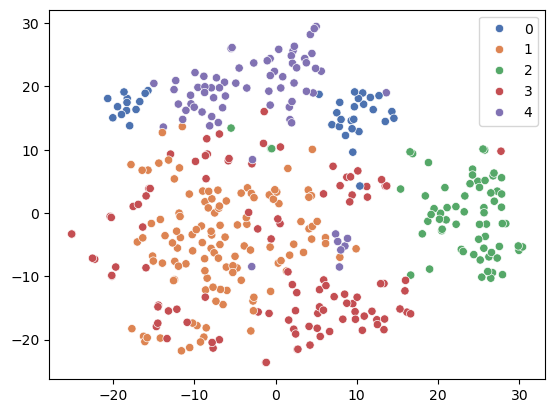

In [15]:
# 创建一个TSNE对象，指定要降维到的维数为2，随机数种子为RANDOM_STATE
tsne = sklearn.manifold.TSNE(n_components=2, random_state=RANDOM_STATE, init="random")

# 调用TSNE对象的fit_transform方法，传入X_simple数据集，返回一个降维后的数据数组，赋值给X_tsne
X_tsne = tsne.fit_transform(X_simple)

sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels, palette="deep") # 散点图

通过上图显示，简单聚类可以成功聚类，但是结果有所粘连
#### 4.2 复杂聚类
通过使用3.2中得到的`X_pasage`进行聚类，并聚集10类

In [16]:
model = KMeans(n_clusters=10,  init='k-means++', max_iter=100, n_init=1, random_state=RANDOM_STATE) # KMean聚类
model.fit(X_passage)
labels = model.labels_
data_df['label'] = labels
labels

array([2, 4, 3, 4, 0, 0, 8, 2, 4, 0, 5, 6, 2, 4, 6, 8, 3, 4, 4, 0, 1, 9,
       3, 2, 2, 8, 4, 5, 4, 8, 3, 5, 2, 2, 7, 9, 2, 7, 8, 7, 2, 1, 2, 6,
       3, 9, 2, 4, 4, 5, 4, 4, 4, 4, 2, 1, 9, 7, 1, 2, 3, 2, 4, 8, 4, 3,
       9, 3, 8, 9, 3, 9, 2, 2, 8, 8, 9, 7, 8, 3, 1, 4, 4, 0, 8, 1, 2, 3,
       8, 2, 2, 4, 6, 1, 2, 5, 0, 7, 8, 4, 9, 4, 2, 4, 6, 5, 7, 6, 8, 9,
       7, 5, 0, 9, 3, 5, 4, 7, 2, 0, 4, 2, 6, 6, 3, 8, 2, 6, 2, 9, 2, 1,
       6, 2, 3, 3, 8, 0, 6, 4, 9, 2, 6, 4, 2, 8, 5, 2, 6, 7, 2, 0, 6, 3,
       2, 5, 4, 6, 2, 4, 2, 3, 9, 2, 5, 8, 3, 1, 9, 3, 9, 3, 6, 9, 9, 2,
       8, 5, 3, 9, 9, 3, 8, 0, 1, 5, 4, 5, 3, 7, 7, 3, 5, 2, 2, 6, 6, 3,
       5, 2, 5, 6, 8, 4, 4, 9, 6, 8, 0, 1, 2, 2, 6, 4, 8, 4, 6, 2, 6, 0,
       4, 2, 8, 1, 3, 2, 4, 4, 4, 8, 6, 8, 2, 7, 4, 5, 3, 6, 5, 8, 2, 4,
       2, 2, 4, 4, 8, 5, 2, 2, 5, 0, 7, 2, 2, 4, 5, 0, 2, 2, 2, 3, 4, 0,
       2, 7, 5, 4, 1, 4, 3, 2, 3, 5, 2, 2, 8, 5, 2, 9, 4, 6, 2, 5, 5, 0,
       2, 9, 2, 4, 1, 9, 5, 2, 9, 3, 9, 4, 2, 2, 2,

In [17]:
data_df[data_df['label']==9][['title', 'groups', 'topics']]

,title,groups,topics
21,The Complexity of Reasoning with FODD and GFODD,Knowledge Representation and Reasoning (KRR),KRR: Automated Reasoning and Theorem Proving\r...
35,PREGO: An Action Language for Belief-Based Cog...,Knowledge Representation and Reasoning (KRR),"KRR: Action, Change, and Causality\r\nKRR: Kno..."
45,Recovering from Selection Bias in Causal and S...,Knowledge Representation and Reasoning (KRR)\r...,"KRR: Action, Change, and Causality\r\nRU: Baye..."
56,A Parameterized Complexity Analysis of General...,Game Playing and Interactive Entertainment (GP...,GTEP: Social Choice / Voting\r\nKRR: Computati...
66,Querying Inconsistent Description Logic Knowle...,Knowledge Representation and Reasoning (KRR),KRR: Ontologies\r\nKRR: Computational Complexi...
69,Knowledge Graph Embedding by Translating on Hy...,Knowledge Representation and Reasoning (KRR)\r...,KRR: Knowledge Representation (General/Other)\...
71,Fast consistency checking of very large real-w...,Knowledge Representation and Reasoning (KRR)\r...,"KRR: Geometric, Spatial, and Temporal Reasonin..."
76,The Computational Complexity of Structure-Base...,Knowledge Representation and Reasoning (KRR)\r...,"KRR: Action, Change, and Causality\r\nKRR: Com..."
100,A Tractable Approach to ABox Abduction over De...,Knowledge Representation and Reasoning (KRR),KRR: Description Logics\r\nKRR: Diagnosis and ...
109,Reasoning on LTL on Finite Traces: Insensitivi...,Knowledge Representation and Reasoning (KRR),AIW: AI for web services: semantic description...


通过查看每组聚类结果可知，每类结果有较为清晰的特征：
- 0：该类主要包含 VIS 等视觉相关文章
- 1：该类主要包含 AIW 及 ROB 等文章
- 2：该类主要包含 NMLA 机器学习等文章
- 3：该类主要包含 GTEP 游戏类文章
- 4：该类主要包含 AIW 及社交网络等文章
- 5：该类主要包含 SCS 和 HSO等搜索类文章
- 6：该类主要包含 PS 及 CS 策略计划类文章
- 7：该类主要包含 GTEP 等文章
- 8：该类主要保护 APP 及 MLA等文章
- 9：该类主要包含 KRR 知识表示与推理等文章

<Axes: >

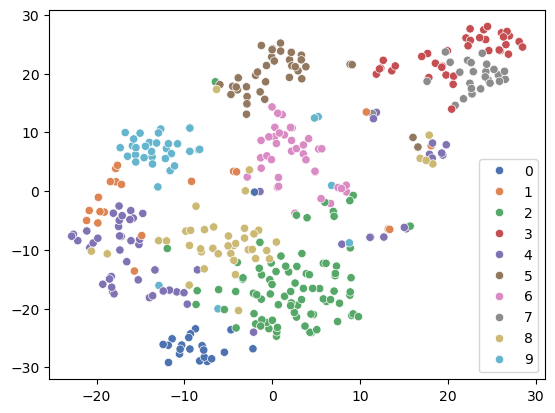

In [18]:
# 创建一个TSNE对象，指定要降维到的维数为2，随机数种子为RANDOM_STATE
tsne = sklearn.manifold.TSNE(n_components=2, random_state=RANDOM_STATE, init="random")

# 调用TSNE对象的fit_transform方法，传入X_passage数据集，返回一个降维后的数据数组，赋值给X_tsne
X_tsne = tsne.fit_transform(X_passage)

sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels, palette="deep") # 散点图

从上图可知，通过作者、词干等分词后，聚类效果更好
### 5 聚类效果分析
本章分析不同k值对聚类效果的影响，以及该数据集中k取什么效果最好

In [19]:
k_range = range(5,15)
label_dict = {}
for k in k_range:
    model = KMeans(n_clusters=k,  init='k-means++', max_iter=100, n_init=1, random_state=RANDOM_STATE)
    model.fit(X_passage)
    labels = model.labels_
    label_dict[k]=labels
label_dict[7]

array([0, 0, 5, 6, 3, 3, 3, 0, 6, 3, 4, 0, 0, 6, 2, 3, 5, 6, 6, 3, 3, 1,
       5, 0, 0, 3, 6, 4, 6, 6, 5, 4, 0, 0, 5, 1, 0, 5, 6, 5, 0, 1, 0, 3,
       5, 1, 0, 3, 3, 4, 6, 6, 6, 3, 0, 6, 1, 5, 3, 0, 5, 0, 6, 3, 6, 5,
       1, 5, 3, 1, 5, 1, 0, 0, 6, 3, 1, 5, 3, 5, 6, 3, 6, 3, 3, 6, 0, 5,
       3, 0, 0, 6, 2, 3, 0, 4, 3, 5, 3, 3, 1, 6, 0, 6, 1, 4, 5, 2, 3, 1,
       5, 4, 3, 1, 5, 4, 6, 3, 0, 3, 3, 0, 3, 2, 5, 3, 0, 2, 0, 1, 0, 1,
       1, 0, 5, 5, 3, 3, 2, 3, 1, 0, 3, 6, 0, 3, 4, 0, 2, 5, 0, 3, 3, 5,
       0, 4, 6, 2, 0, 6, 0, 5, 1, 0, 4, 3, 5, 6, 2, 5, 1, 5, 2, 1, 1, 0,
       3, 4, 5, 1, 1, 5, 3, 3, 1, 4, 3, 6, 5, 5, 5, 5, 4, 0, 0, 1, 2, 5,
       4, 0, 4, 2, 3, 3, 6, 1, 2, 3, 3, 6, 0, 3, 1, 3, 3, 6, 2, 0, 2, 3,
       6, 3, 3, 3, 5, 0, 3, 6, 3, 3, 1, 3, 0, 5, 6, 4, 5, 2, 4, 3, 0, 3,
       0, 0, 6, 6, 3, 4, 0, 0, 4, 3, 5, 0, 0, 6, 2, 3, 0, 0, 0, 5, 6, 3,
       0, 5, 4, 0, 6, 6, 5, 0, 5, 4, 0, 0, 3, 4, 0, 1, 3, 2, 0, 4, 4, 3,
       0, 1, 0, 6, 6, 1, 4, 0, 1, 5, 3, 6, 0, 0, 0,

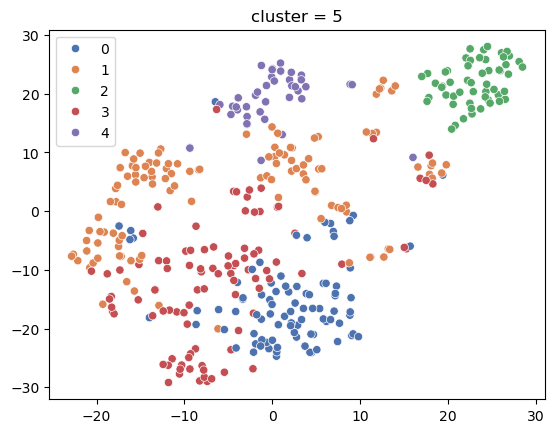

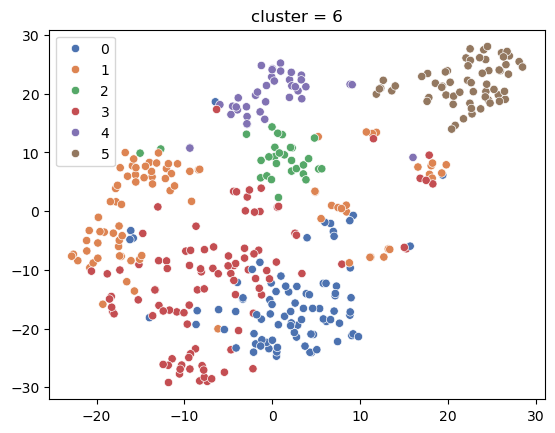

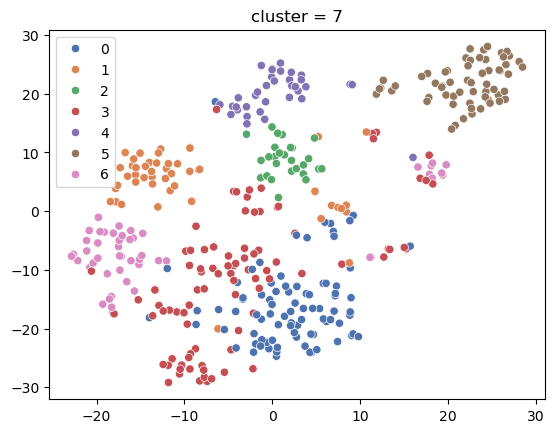

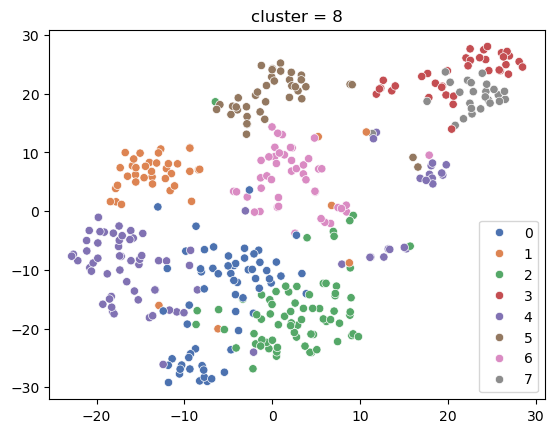

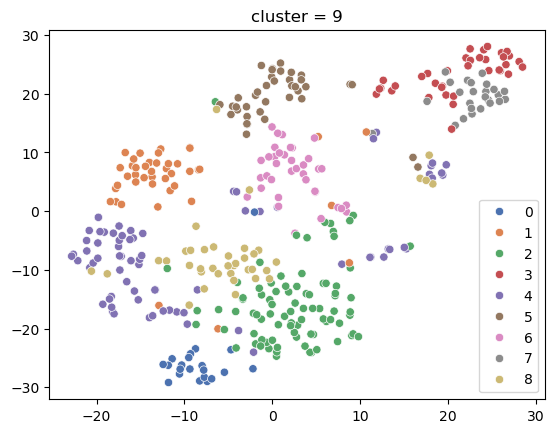

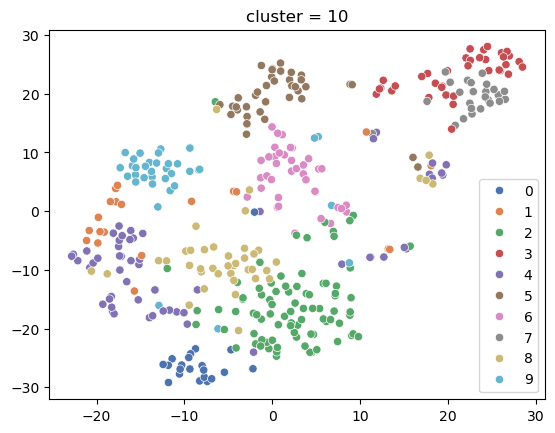

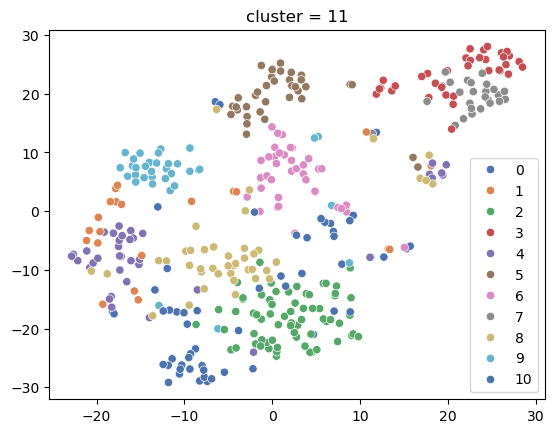

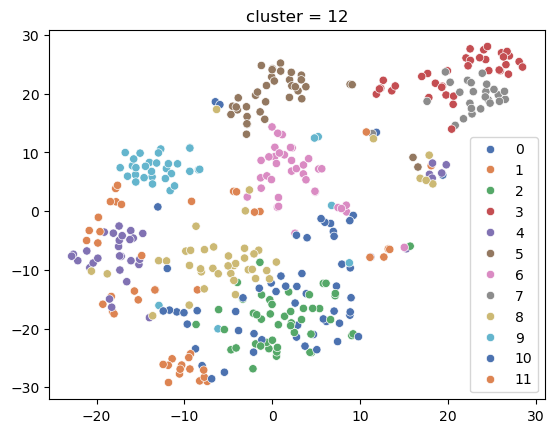

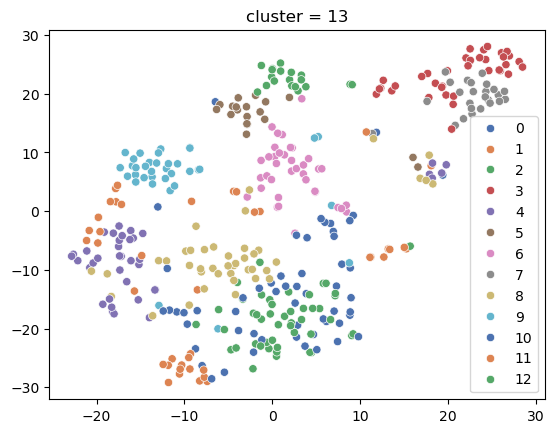

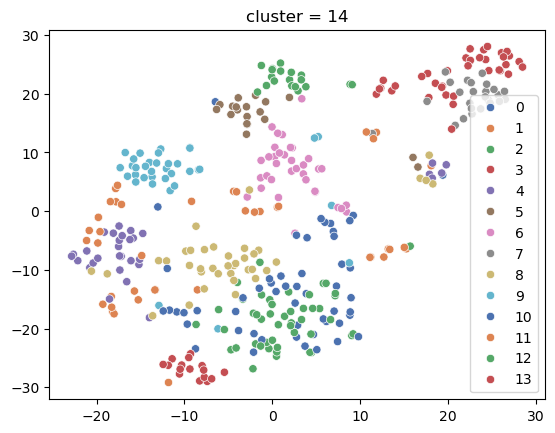

In [20]:
for k,label in label_dict.items():
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=label, palette="deep") # 散点图
    plt.title("cluster = %d"% k)
    plt.show()


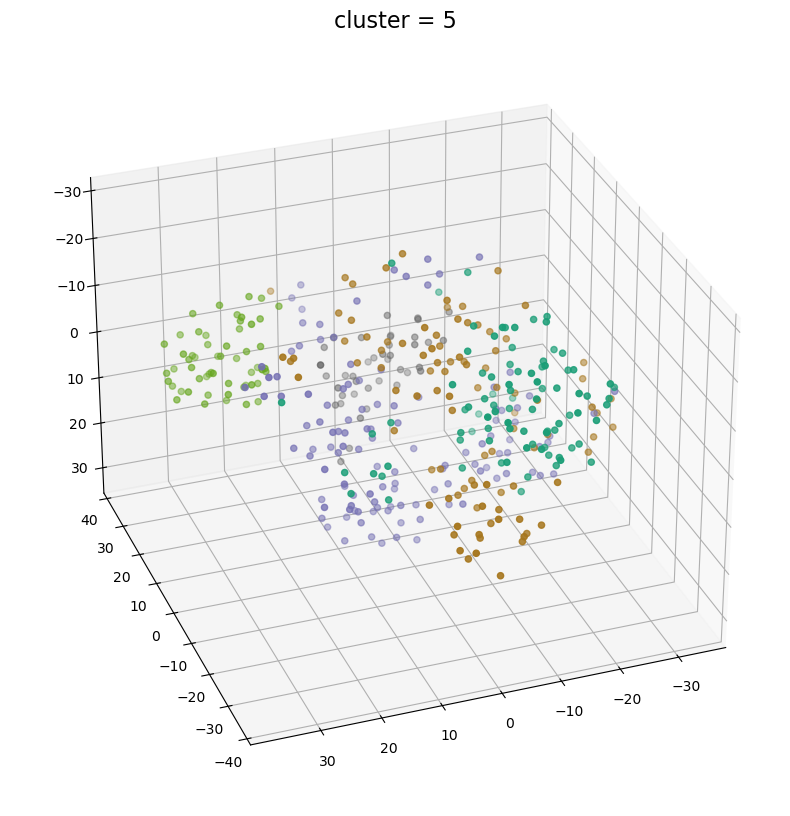

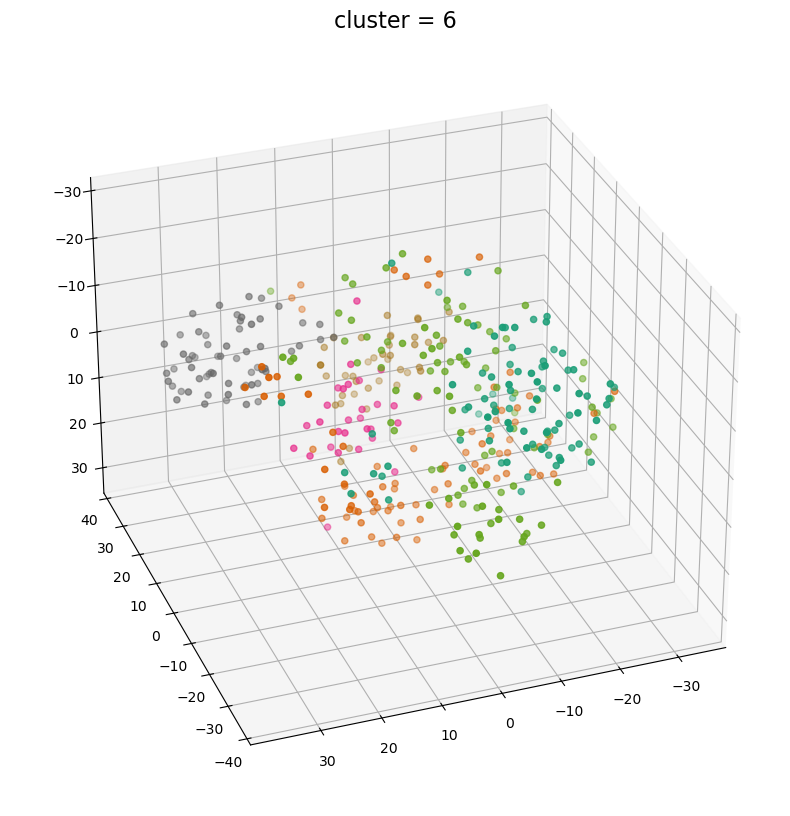

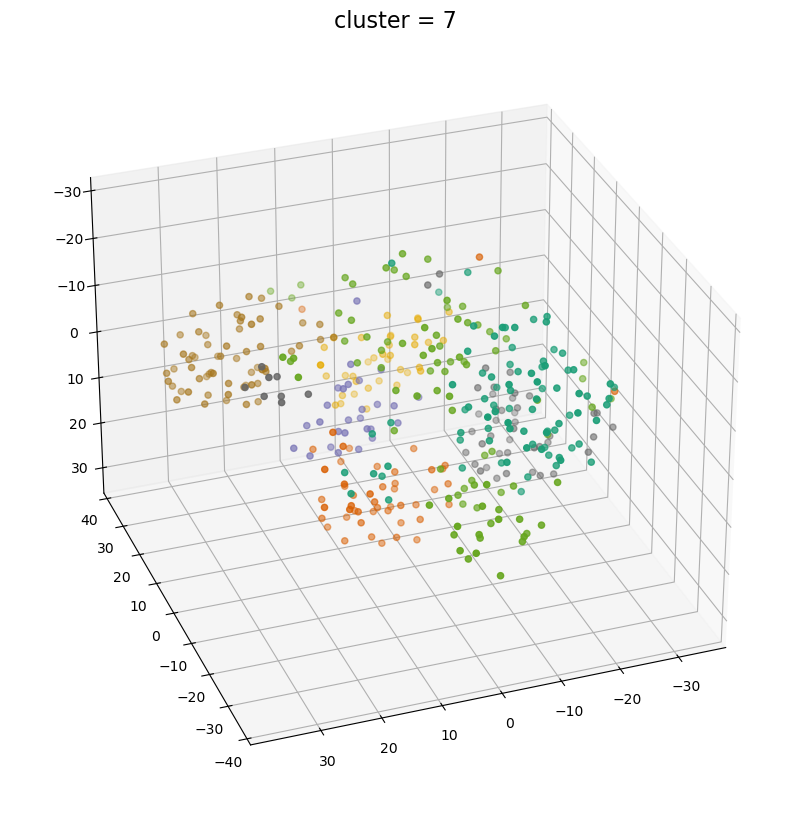

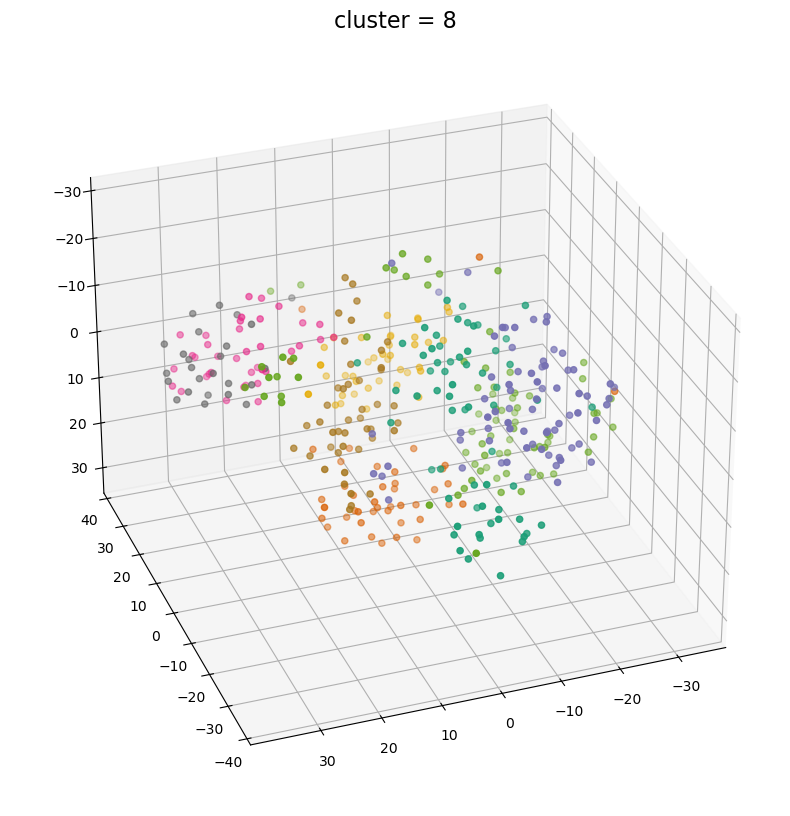

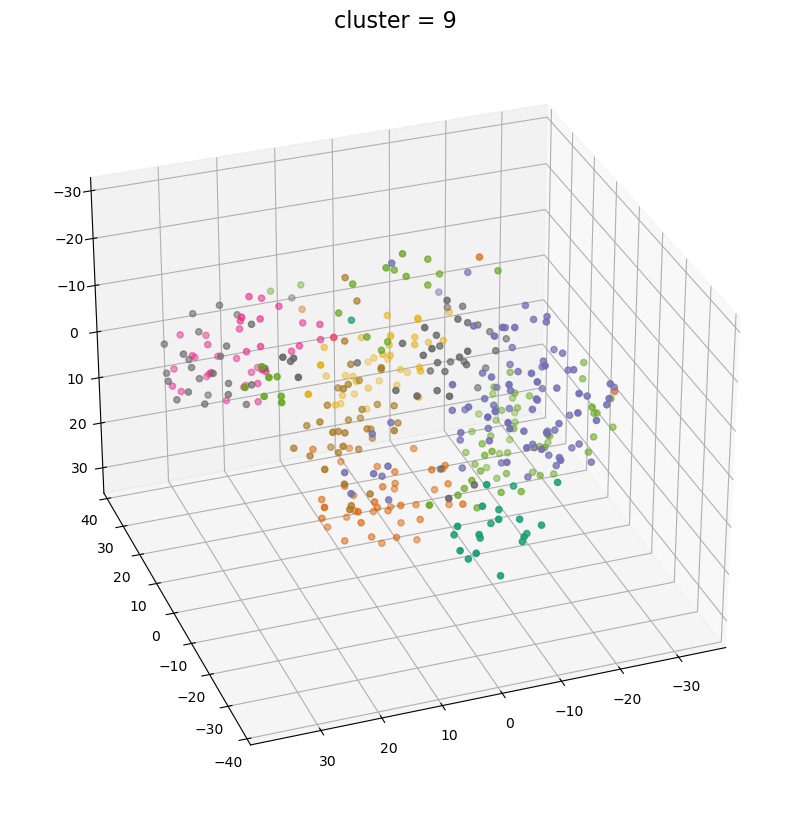

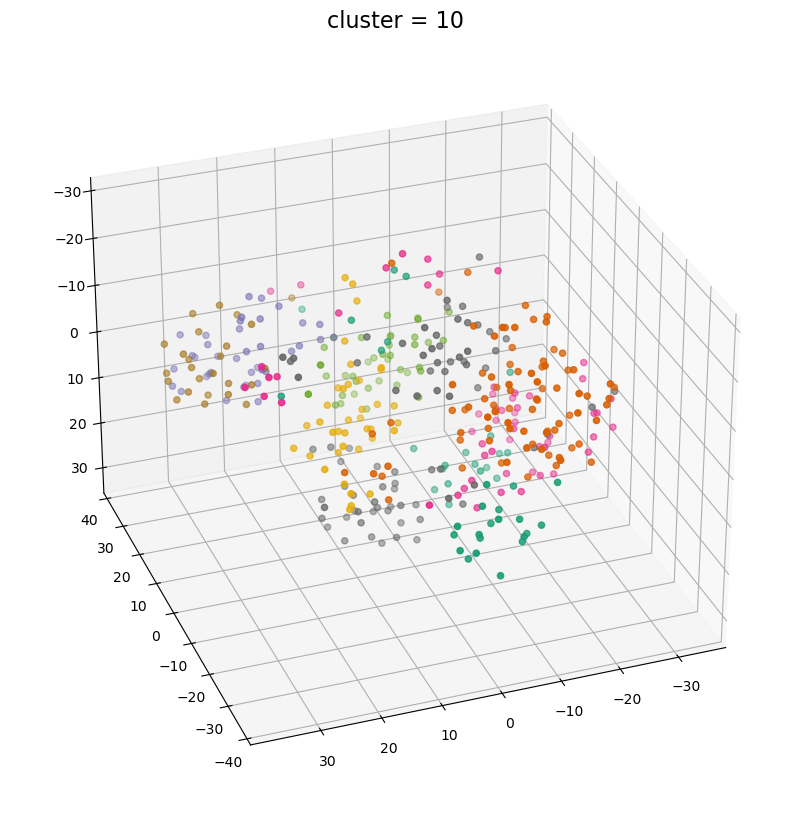

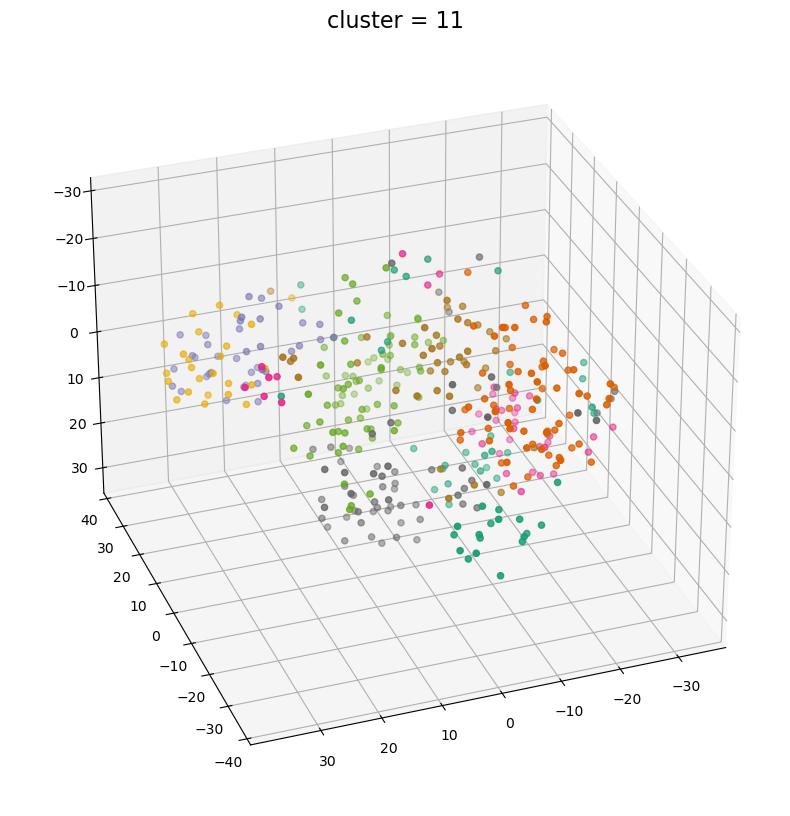

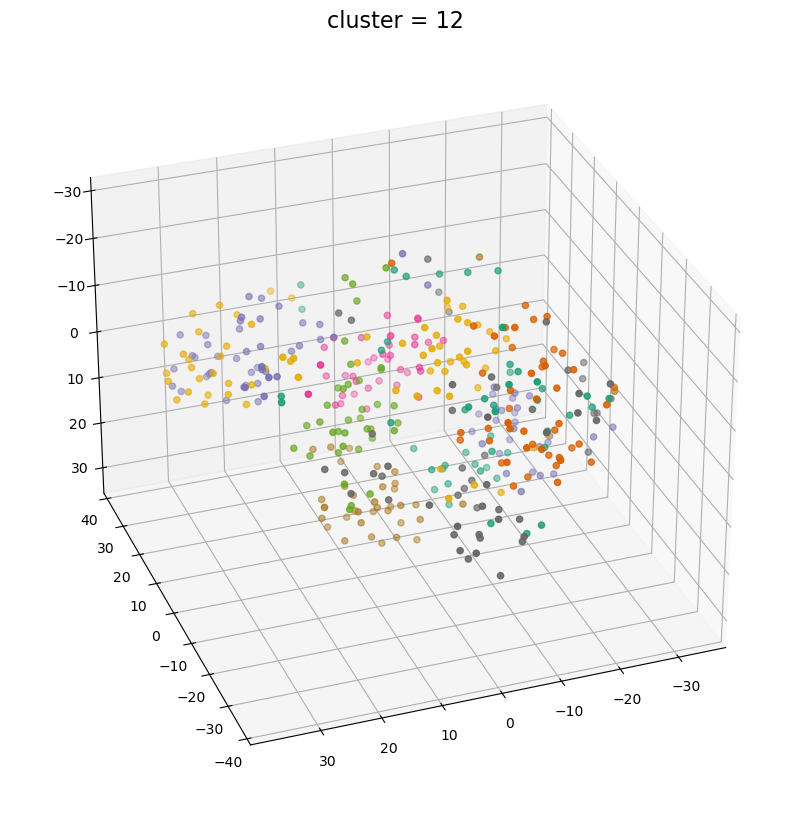

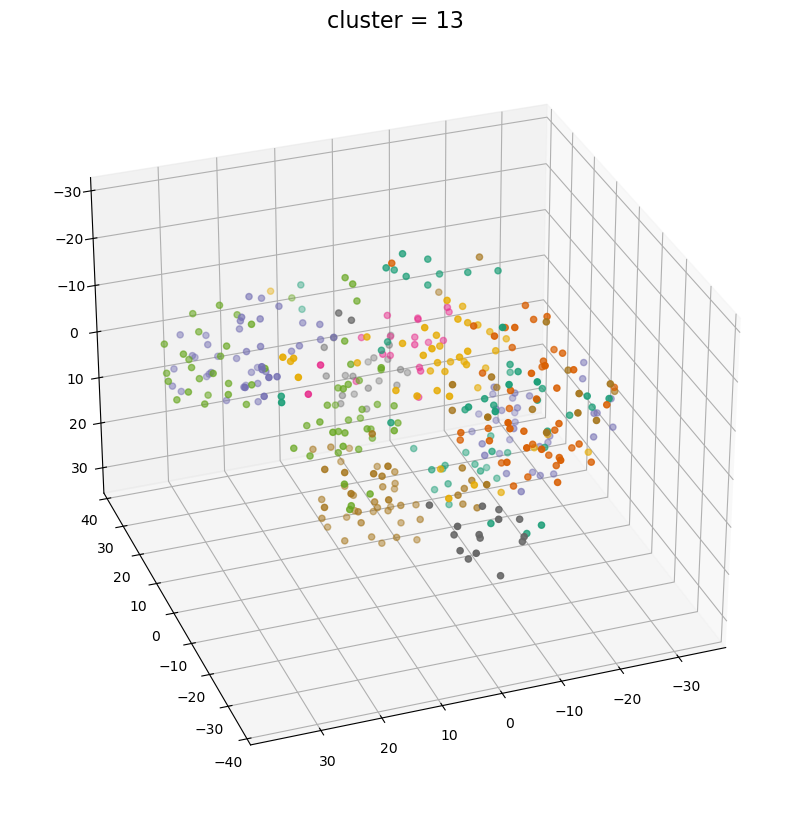

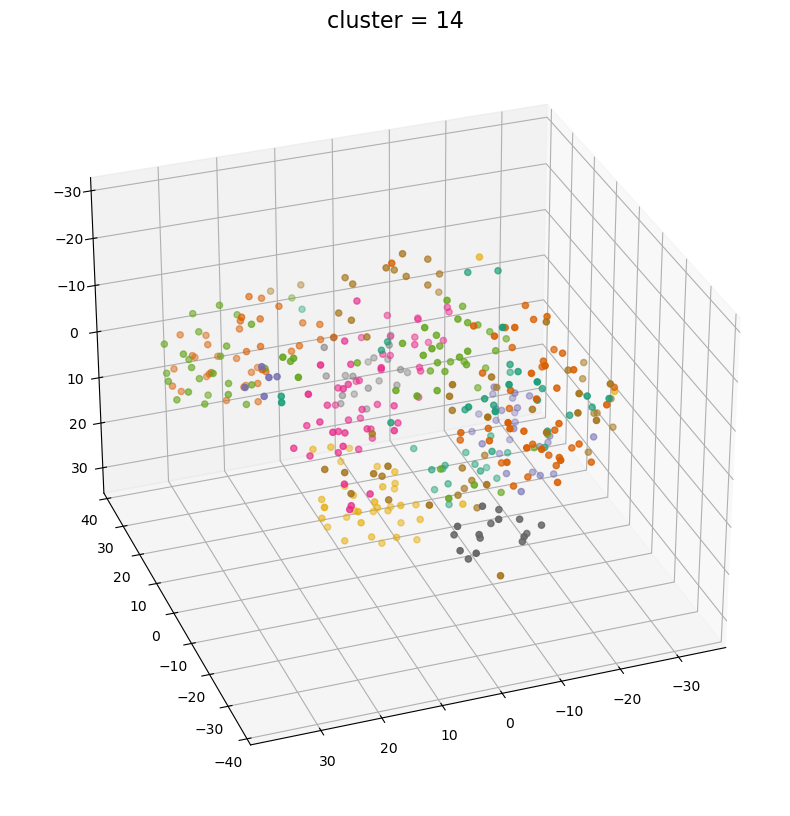

In [21]:
# 创建一个TSNE对象，指定要降维到的维数为3，随机数种子为RANDOM_STATE
tsne = sklearn.manifold.TSNE(n_components=3, random_state=RANDOM_STATE, init="random")

# 调用TSNE对象的fit_transform方法，传入X_simple数据集，返回一个降维后的数据数组，赋值给X_tsne
X_tsne = tsne.fit_transform(X_passage)

for k,label in label_dict.items():
    # 创建一个图形对象，指定图形的宽度和高度
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)
    # 绘制散点图，指定散点的大小
    ax.scatter(X_tsne[:, 0],X_tsne[:, 1],X_tsne[:, 2],c=label_dict[k],cmap='Dark2')
    # 设置标题，指定标题的字体大小
    plt.title("cluster = %d"% k, fontsize=16)
    plt.show()


以上可见，用2d和3d图展示聚类效果，在5到14的Kmeans中没有聚类效果特别好的，但是感觉取7时聚类效果更好一点